<a href="https://colab.research.google.com/github/ak-ghoul/Deep-Learning/blob/master/EncoderDecoder_EngtoHindi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

import random
import string

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
all_letters = string.ascii_uppercase
print(all_letters)

ABCDEFGHIJKLMNOPQRSTUVWXYZ


In [3]:
pad_char = '-PAD-'
eng_letter_index = {}
eng_letter_index[pad_char] = 0
for index, letter in enumerate(all_letters):  # always use enumerate whenever dealing with indices & values of ant data structure in python
  eng_letter_index[letter] = index + 1
print(eng_letter_index)

{'-PAD-': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26}


In [4]:
# Hindi Unicode Hex Range is 2304:2432   |   Source : https://asecuritysite.com/coding/asc2?val=2304%2C2560

hindi_letter_index = {}
hindi_letter_index[pad_char] = 0
c = 1
for i in range(2304, 2432):
  hindi_letter_index[chr(i)] = c
  c += 1
print(hindi_letter_index)

{'-PAD-': 0, 'ऀ': 1, 'ँ': 2, 'ं': 3, 'ः': 4, 'ऄ': 5, 'अ': 6, 'आ': 7, 'इ': 8, 'ई': 9, 'उ': 10, 'ऊ': 11, 'ऋ': 12, 'ऌ': 13, 'ऍ': 14, 'ऎ': 15, 'ए': 16, 'ऐ': 17, 'ऑ': 18, 'ऒ': 19, 'ओ': 20, 'औ': 21, 'क': 22, 'ख': 23, 'ग': 24, 'घ': 25, 'ङ': 26, 'च': 27, 'छ': 28, 'ज': 29, 'झ': 30, 'ञ': 31, 'ट': 32, 'ठ': 33, 'ड': 34, 'ढ': 35, 'ण': 36, 'त': 37, 'थ': 38, 'द': 39, 'ध': 40, 'न': 41, 'ऩ': 42, 'प': 43, 'फ': 44, 'ब': 45, 'भ': 46, 'म': 47, 'य': 48, 'र': 49, 'ऱ': 50, 'ल': 51, 'ळ': 52, 'ऴ': 53, 'व': 54, 'श': 55, 'ष': 56, 'स': 57, 'ह': 58, 'ऺ': 59, 'ऻ': 60, '़': 61, 'ऽ': 62, 'ा': 63, 'ि': 64, 'ी': 65, 'ु': 66, 'ू': 67, 'ृ': 68, 'ॄ': 69, 'ॅ': 70, 'ॆ': 71, 'े': 72, 'ै': 73, 'ॉ': 74, 'ॊ': 75, 'ो': 76, 'ौ': 77, '्': 78, 'ॎ': 79, 'ॏ': 80, 'ॐ': 81, '॑': 82, '॒': 83, '॓': 84, '॔': 85, 'ॕ': 86, 'ॖ': 87, 'ॗ': 88, 'क़': 89, 'ख़': 90, 'ग़': 91, 'ज़': 92, 'ड़': 93, 'ढ़': 94, 'फ़': 95, 'य़': 96, 'ॠ': 97, 'ॡ': 98, 'ॢ': 99, 'ॣ': 100, '।': 101, '॥': 102, '०': 103, '१': 104, '२': 105, '३': 106, '४': 107, '५': 108, '६': 109, '७': 

In [5]:
import re 
non_eng_letters_regx = re.compile('[^a-zA-Z ]') # space at last ensures space b/w words will be retained
print(non_eng_letters_regx)

# Remove all English non-letters
def del_noneng_letters(line):
  line = line.replace('-', ' ').replace(',', ' ').upper()
  line = non_eng_letters_regx.sub('', line)   # substitute anything which is not in [^a-zA-Z ] in the line with nothing i.e. remove em
  return line.split()

def del_nonhindi_letters(line):
  line = line.replace('-', ' ').replace(',', ' ')
  clean_hindi_line = ''
  for letter in line:
    if letter in hindi_letter_index or letter == ' ':
      clean_hindi_line += letter
  return clean_hindi_line.split()

re.compile('[^a-zA-Z ]')


In [0]:
from torch.utils.data import Dataset
import xml.etree.ElementTree as ET

class TransliterationDataLoader(Dataset):            # class to deal with xml dataset
    def __init__(self, filename):
        self.eng_words, self.hindi_words = self.readXmlDataset(filename, del_nonhindi_letters)
        self.shuffle_indices = list(range(len(self.eng_words)))
        random.shuffle(self.shuffle_indices)
        self.shuffle_start_index = 0
        
    def __len__(self):
        return len(self.eng_words)
    
    def __getitem__(self, idx):
        return self.eng_words[idx], self.hindi_words[idx]
    
    def readXmlDataset(self, filename, lang_vocab_cleaner):
        transliterationCorpus = ET.parse(filename).getroot()   # the root tag of the xml file is transliterationCorpus
        lang1_words = []
        lang2_words = []

        for line in transliterationCorpus:
            wordlist1 = del_noneng_letters(line[0].text)
            wordlist2 = lang_vocab_cleaner(line[1].text)

            # Skip noisy data
            if len(wordlist1) != len(wordlist2):
                print('Skipping: ', line[0].text, ' - ', line[1].text)
                continue

            for word in wordlist1:
                lang1_words.append(word)
            for word in wordlist2:
                lang2_words.append(word)

        return lang1_words, lang2_words
    
    def get_random_sample(self):
        return self.__getitem__(np.random.randint(len(self.eng_words)))
    
    def get_batch_from_array(self, batch_size, array):
        end = self.shuffle_start_index + batch_size
        batch = []
        if end >= len(self.eng_words):
            batch = [array[i] for i in self.shuffle_indices[0:end%len(self.eng_words)]]
            end = len(self.eng_words)
        return batch + [array[i] for i in self.shuffle_indices[self.shuffle_start_index : end]]
    
    def get_batch(self, batch_size, postprocess = True):
        eng_batch = self.get_batch_from_array(batch_size, self.eng_words)
        hindi_batch = self.get_batch_from_array(batch_size, self.hindi_words)
        self.shuffle_start_index += batch_size + 1
        
        # Reshuffle if 1 epoch is complete
        if self.shuffle_start_index >= len(self.eng_words):
            random.shuffle(self.shuffle_indices)
            self.shuffle_start_index = 0
            
        return eng_batch, hindi_batch

In [8]:
train_set = TransliterationDataLoader('rI58TOlAScioEuPBbOYh_NEWS2012TrainingEnHi13937-1563719470862.xml')
test_set = TransliterationDataLoader('njThAK0RQGeoOuE9rfwg_NEWS2012RefEnHi1000-1563719263404.xml')

Skipping:  BARHARWA JUNCTION  -  बरहरवा
Skipping:  STATE BNK TR  -  स्टेट बैंक ऑफ त्रावणकोर
Skipping:  SOUTH ARLINGTON CHURCH OF CHRIST  -  साउथ अर्लिंग्टन
Skipping:  KING EDWARD VII  -  किंग एडवर्ड
Skipping:  DIBANG VALLEY  -  दिबंगवैली
Skipping:  ORDER OF VASA  -  ऑडर ऑफ़ द वासा
Skipping:  AZAMNAGAR ROAD  -  आज़मनगर
Skipping:  CAPE TOWN  -  केपटाउन
Skipping:  NEW ZEALAND  -  न्यूज़ीलैंड
Skipping:  SEA OF THE HEBRIDES  -  सी ऑफ हरब्रिड्‍स
Skipping:  RAMCOIND  -  राम्को इंड
Skipping:  KELVINGROVE ART GALLERY AND MUSEUM  -  केल्व‍िनग्रोव आर्ट एण्ड म्युज़ियम
Skipping:  AUSTRALIAN NATIONAL UNIVERSITY  -  ऑस्ट्रेलियननेशनल यूनिवर्सिटी
Skipping:  JAHAN AARA  -  जहाँआरा
Skipping:  NAVABHARAT FERRO ALLOYS  -  नव भारत फ़ैरो अलॉय
Skipping:  RAMA LINGESHWARA  -  रामालिंगेश्वर
Skipping:  FAKHRUN NISA  -  फखरुन्निसा
Skipping:  REDIFF.COM INDIA LIMITED  -  रेडिफ़ डॉट कॉम इंडिया लिमिटेड
Skipping:  OMKARNATH THAKUR  -  ओंकार नाथ ठाकुर
Skipping:  OPENTV  -  ओपन टीवी
Skipping:  ENVOY COMMUNICATIONS GROUP  

## Encoding the Words

In [0]:
def input_engword_rep(word):        # converting input word to one hot representation
  oh_input_vector = torch.zeros(len(word)+1, 1, len(eng_letter_index)).to(device)  # one xtra is taken on x axis to put pad at last x index
  for index, letter in enumerate(word):
    pos = eng_letter_index[letter]
    oh_input_vector[index][0][pos] = 1
  pad_pos = eng_letter_index[pad_char]
  oh_input_vector[index+1][0][pad_pos] = 1
  return oh_input_vector

def output_hindiword_rep(word):   # converting output hindi characters to tensors.     O/P is not converted into one hot, only input
  output_hindi_index_tensor = torch.zeros([len(word)+1, 1], dtype = torch.long).to(device)   # no 3d, 2d because conversion to tensors no OH
  for index, letter in enumerate(word):
    pos = hindi_letter_index[letter]
    output_hindi_index_tensor[index][0] = pos
  pad_pos = hindi_letter_index[pad_char]
  output_hindi_index_tensor[index+1][0] = 0
  return output_hindi_index_tensor

In [10]:
eng, hindi = train_set.get_random_sample()  # if random val from a dataset required. | np.random only when b/w range is known
print(eng, hindi)
print(input_engword_rep(eng))
print(output_hindiword_rep(hindi))

PHOTOGRAPHY फोटोग्राफी
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [0]:
MAX_OUTPUT_CHARS = 30
class Transliteration_EncoderDecoder(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, verbose = False):
    super(Transliteration_EncoderDecoder, self).__init__()

    self.hidden_size = hidden_size
    self.output_size = output_size

    self.encoder_rnn_cell = nn.GRU(input_size, hidden_size)
    self.decoder_rnn_cell = nn.GRU(output_size, hidden_size)   # final o/p of decoder is given as  

    self.h2o = nn.Linear(hidden_size, output_size)   # hidden to output
    self.SoftMax = nn.LogSoftmax(dim = 2)

    self.verbose = verbose

  def forward(self, input, max_output_chars = MAX_OUTPUT_CHARS, device = 'cpu', ground_truth = None):

    # encoder
    output, hidden = self.encoder_rnn_cell(input)

    if self.verbose:
      print('Encoder input :', input.shape)
      print('Encoder output :', output.shape)
      print('Encoder hidden :', hidden.shape)
    
    # decoder
    decoder_state = hidden
    decoder_input = torch.zeros(1, 1, self.output_size).to(device)
    outputs = []

    if self.verbose:
      print('Decoder state :', decoder_state.shape)
      print('Decoder input :', decoder_input.shape)

    for i in range(max_output_chars):
      out, decoder_state = self.decoder_rnn_cell(decoder_input, decoder_state)
    
      out = self.h2o(decoder_state)  # to convert the dimensions of the decoder_state
      out = self.SoftMax(out)
      outputs.append(out.view(1, -1))

      max_idx = torch.argmax(out, 2, keepdim=True)
      if not ground_truth is None:
        max_idx = ground_truth[i].reshape(1, 1, 1)
      one_hot = torch.FloatTensor(out.shape).to(device)
      one_hot.zero_()
      one_hot.scatter_(2, max_idx, 1)
            
      decoder_input = one_hot.detach()  # detach is done to stop calculating gradients for the connections when output is passed to next hidden layer
      # gradient of every connection is calculated from the backward pass but calculation of these new connections decreases efficiency
      
    return outputs

In [0]:
net = Transliteration_EncoderDecoder(len(eng_letter_index), 256, len(hindi_letter_index), True)

##  Attention Encoder Decoder

In [0]:
class Transliteration_EncoderDecoder_Attention(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, verbose = False):
    super(Transliteration_EncoderDecoder_Attention, self).__init__()
    self.hidden_size = hidden_size   # self assigned to use it outside init in other funcs
    self.output_size = output_size

    self.encoder_rnn_cell = nn.GRU(input_size, hidden_size)
    self.decoder_rnn_cell = nn.GRU(hidden_size * 2, hidden_size)   # 2*hidden because one from attention & other from decoder output. doubles the size

    self.h2o = nn.Linear(hidden_size, output_size)  
    self.SoftMax = nn.LogSoftmax(dim = 2)

    self.verbose = verbose

    self.U = nn.Linear(hidden_size, hidden_size)     # e(j, t) = Vattn. * tanh(Uattn. * h + Wattn. * s) 
    self.W = nn.Linear(hidden_size, hidden_size)    
    self.attn = nn.Linear(hidden_size, 1)    # self.attn is Vattn. from equation
    self.o2h = nn.Linear(output_size, hidden_size)   #  for calculation of attention vector

  def forward(self, input, max_output_chars = MAX_OUTPUT_CHARS, device = 'cpu', ground_truth = None):

    # encoder
    encoder_output, hidden = self.encoder_rnn_cell(input)
    encoder_output = encoder_output.view(-1, self.hidden_size)

    if self.verbose:
      print('Encoder Output', encoder_output.shape)

    # decoder
    decoder_state = hidden   # initial decoder state is assigned hidden from the encoder. That connection encoder -> decoder
    decoder_input = torch.zeros(1, 1, self.output_size).to(device)  # initial decoder input is all 0's tensor. later one hot passes from decoder_output

    outputs = []
    U = self.U(encoder_output)

    if self.verbose:
      print('Decoder State:', decoder_state.shape)
      print('Decoder Input:', decoder_input.shape)
      print('U * Encoder Output:', U.shape)

    for i in range(max_output_chars):

      W = self.W(decoder_state.view(1, -1).repeat(encoder_output.shape[0], 1))
      V = self.attn(torch.tanh(U + W))
      attn_weights = F.softmax(V.view(1, -1), dim = 1)

      attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_output.unsqueeze(0))  # batch matrix multiplication. 
      # unsqueeze makes(x,) as (1, x) if 0 is passed else (x, 1)
      embedding = self.o2h(decoder_input)
      decoder_input = torch.cat((embedding[0], attn_applied[0]), 1).unsqueeze(0) # 1 states dimension along which concatenate

      out, decoder_state = self.decoder_rnn_cell(decoder_input, decoder_state)
            
      if self.verbose:
        print('Decoder intermediate output', out.shape)
                
      out = self.h2o(decoder_state)
      out = self.SoftMax(out)
      outputs.append(out.view(1, -1))
        
      if self.verbose:
        print('Decoder output', out.shape)
        self.verbose = False
            
      max_idx = torch.argmax(out, 2, keepdim=True)
      if not ground_truth is None:
        max_idx = ground_truth[i].reshape(1, 1, 1)
      one_hot = torch.zeros(out.shape, device=device)
      one_hot.scatter_(2, max_idx, 1) 
            
      decoder_input = one_hot.detach()
            
    return outputs


In [0]:
net_attn = Transliteration_EncoderDecoder_Attention(len(eng_letter_index), 256, len(hindi_letter_index), verbose = True)

In [0]:
def train_batch(net, opt, criterion, batch_size, device = 'cpu', teacher_force = False):

  net.train().to(device)
  opt.zero_grad()
  eng_word, hindi_word = train_set.get_batch(batch_size)

  total_loss = 0
  for i in range(batch_size):
    input_oh = input_engword_rep(eng_word[i])
    output_tensor = output_hindiword_rep(hindi_word[i])
    outputs = net(input_oh, output_tensor.shape[0], device, output_tensor if teacher_force else None)

    for index, output in enumerate(outputs):
      loss = criterion(output, output_tensor[index]) / batch_size
      loss.backward(retain_graph = True)
      total_loss += loss
    
  opt.step()
  return total_loss/batch_size

In [0]:
def train_setup(net, lr = 0.01, n_batches = 100, batch_size = 10, momentum = 0.9, display_freq=5, device = 'cpu'):
    
    net = net.to(device)
    criterion = nn.NLLLoss(ignore_index = -1)
    opt = optim.Adam(net.parameters(), lr=lr)
    teacher_force_upto = n_batches//3
    
    loss_arr = np.zeros(n_batches + 1)
    
    for i in range(n_batches):
        loss_arr[i+1] = (loss_arr[i]*i + train_batch(net, opt, criterion, batch_size, device = device, teacher_force = i<teacher_force_upto ))/(i + 1)
        
        if i%display_freq == display_freq-1:
            clear_output(wait=True)  # used to clear the previous graph
            
            print('Iteration', i, 'Loss', loss_arr[i])
            plt.figure()
            plt.plot(loss_arr[1:i], '-*')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
            print('\n\n')
            
    torch.save(net, 'model.pt')
    return loss_arr

In [0]:
net = Transliteration_EncoderDecoder(len(eng_letter_index), 256, len(hindi_letter_index))

In [39]:
print(device)
sb.set()

cuda:0


Iteration 1999 Loss 0.17757657170295715


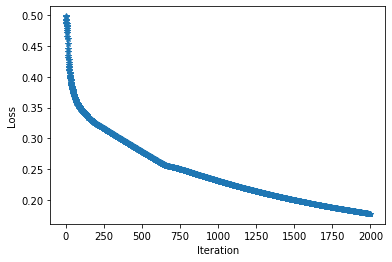

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Transliteration_EncoderDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type GRU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type LogSoftmax. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


array([0.        , 0.49726164, 0.49805546, ..., 0.17760351, 0.17757657,
       0.1775367 ])

In [38]:
train_setup(net, lr=0.001, n_batches=2000, batch_size = 64, display_freq=10, device = device)

In [0]:
net_att = Transliteration_EncoderDecoder_Attention(len(eng_letter_index), 256, len(hindi_letter_index))

Iteration 1999 Loss 0.1446012556552887


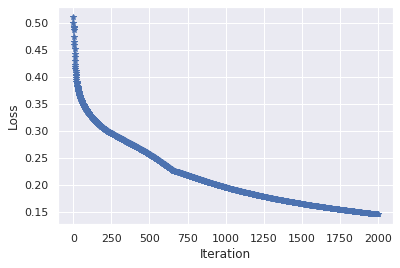

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Transliteration_EncoderDecoder_Attention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type GRU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type LogSoftmax. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked

In [46]:
loss_history = train_setup(net_att, lr=0.001, n_batches=2000, batch_size = 64, display_freq=10, device = device)

In [0]:
  def calc_accuracy(net, device = 'cpu'):
    net = net.eval().to(device)
    predictions = []
    accuracy = 0
    for i in range(len(test_set)):
        eng, hindi = test_set[i]
        gt = output_hindiword_rep(hindi)
        outputs = infer(net, eng, gt.shape[0], device)
        correct = 0
        for index, out in enumerate(outputs):
            val, indices = out.topk(1)
            hindi_pos = indices.tolist()[0]
            if hindi_pos[0] == gt[index][0]:
                correct += 1
        
        accuracy += correct/gt.shape[0]
    accuracy /= len(test_set)
    return accuracy

In [0]:
accuracy = calc_accuracy(net) * 100
accuracy_attn = calc_accuracy(net_att) * 100
print('Accuracy w/o attention ', accuracy)
print('Acurracy with attention', accuracy_attn)